## Incidents analysis from 2010-Current. 

As a sample using 2010-2012

SELECT "coordinates","road","Region","type","loggedtime","blockagetype" FROM "streams_incidents"."incidents_curated" order by "loggedtime";
   

- Kernel Density Estimation of crashes and prediction.
- Poisson Distribution and processes
- Hawakes Method integrating bayesian paradigm
- Neural networks
- Summary and comaprison of findings


In [3]:
import pandas as pd

In [4]:
incidents=pd.read_csv('5e842a5d-9ce0-40ae-8c97-604e5ce153d1.csv')

In [5]:
incidents.describe()

,Region,Hour(HH.MM),Hour(HH.H)
count,0.0,88201.000000,88201.000000
mean,NaN,12.955834,13.161597
std,NaN,4.954652,4.958253
min,NaN,0.000000,0.000000
25%,NaN,9.030000,9.100000
50%,NaN,13.310000,13.500000
75%,NaN,17.030000,17.100000
max,NaN,23.590000,24.000000


In [6]:
incidents.head()

,coordinates,road,Region,type,loggedtime,blockagetype,Hour(HH.MM),Hour(HH.H)
0,"145.242458668,-17.6613188854",KENNEDY HIGHWAY,NaN,Planned Event/Roadworks,11/08/2010 10:20,No Blockage,10.20,10.3
1,"145.496414185,-17.6104373932",KENNEDY HIGHWAY,NaN,Planned Event/Roadworks,22/10/2010 16:04,Partially Blocked,16.04,16.1
2,"153.010772705,-27.4678230286",BOOMERANG STREET,NaN,Stationary Vehicle,1/01/2011 1:33,Unknown,1.33,1.6
3,"153.069381714,-27.5534038544",PACIFIC MOTORWAY,NaN,Stationary Vehicle,1/01/2011 1:46,Unknown,1.46,1.8
4,"153.282180786,-27.8170452118",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 1:52,Unknown,1.52,1.9


In [47]:
incidents_counts=incidents.groupby('Hour(HH.H)').count()

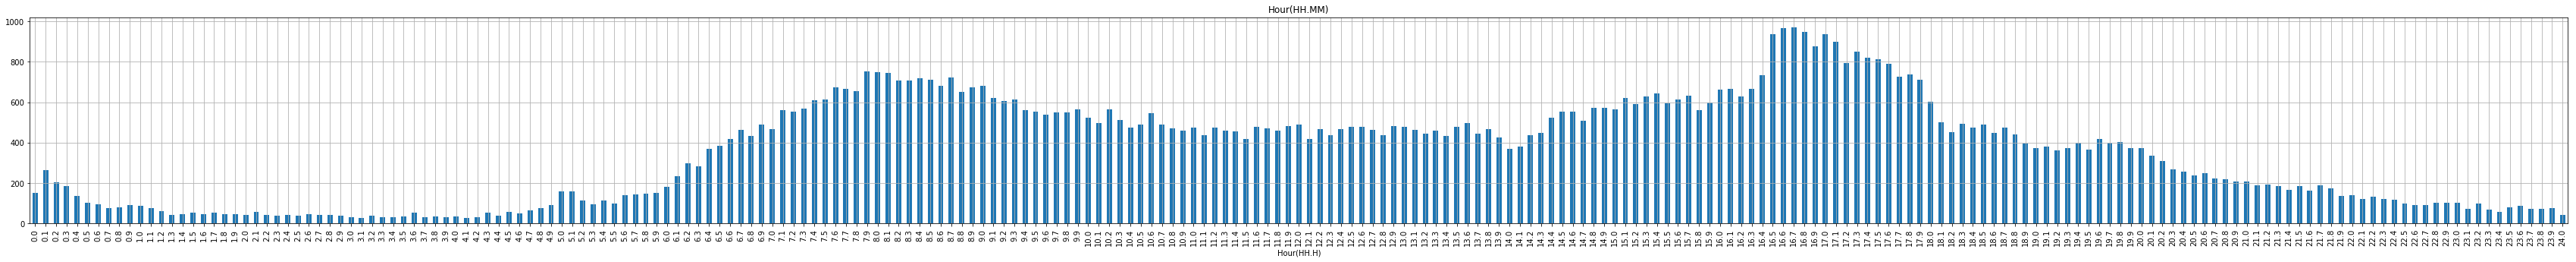

In [48]:
incidents_counts['Hour(HH.MM)'].plot(kind='bar',subplots=True, figsize=(60,5), grid= True);

### The below pivot table highlights crash/congestion and stationary vehicles.

#### Hazard and planned activity and alerts have a different shape/trend

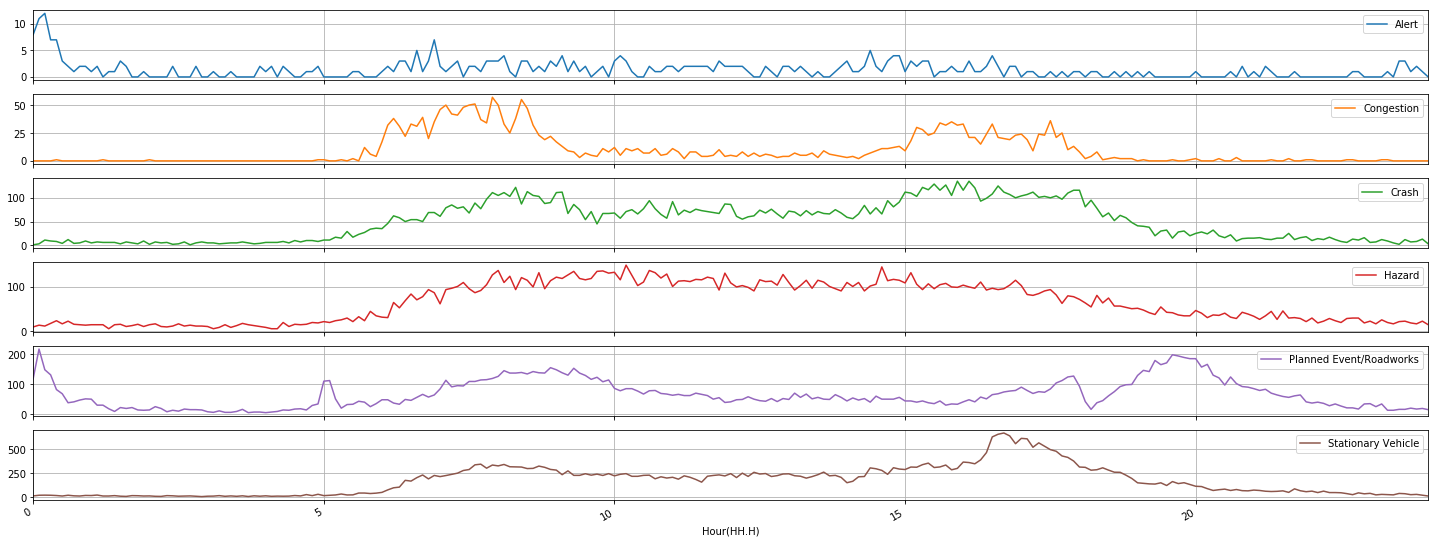

In [14]:
incidents['Indicator'] = 1

incidents.pivot_table(
    index = 'Hour(HH.H)',
    columns ='type',
    values = 'Indicator',   aggfunc=len, fill_value=0).plot(subplots=True, figsize=(25,10), grid= True);

### Extract crashes for analysis

In [117]:
#Extract the crash data 
mask = incidents['type'] == 'Crash'
crashes_incidents = incidents.loc[mask]
#columns_of_interest = ['road','type', 'loggedtime','blockagetype', 'Hour(HH.H)']
columns_of_interest = ['Hour(HH.H)']
crashes_incidents_lite = crashes_incidents[columns_of_interest]
crashes_incidents_lite.describe()

,Hour(HH.H)
count,12133.000000
mean,12.991651
std,4.540612
min,0.000000
25%,9.100000
50%,13.400000
75%,16.600000
max,24.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003EE52080>]],
      dtype=object)

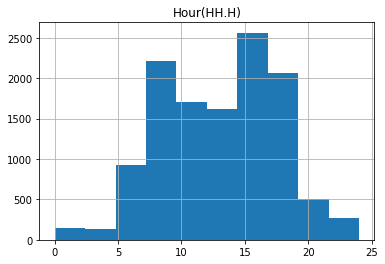

In [26]:
crashes_incidents_lite.hist('Hour(HH.H)')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003B0B94A8>]],
      dtype=object)

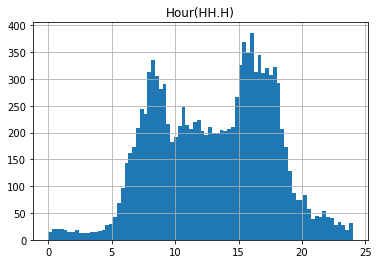

In [27]:
crashes_incidents_lite.hist('Hour(HH.H)',bins=80)

### Non-parametric fitting using kernel denstiy estimation

#### Does not resemble a common probability distribution or cannot be easily made to fit the distribution.
Often the case where there are two peaks (bimodal distribution). An algorithm is used to approximate the probability distribution of the data without a pre-defined distribution, referred to as a nonparametric method.

The most common nonparametric approach for estimating the probability density function of a continuous random variable is called kernel smoothing, or kernel density estimation, KDE for short.

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [56]:
model = gaussian_kde(crashes_incidents_lite['Hour(HH.H)']) #can tune bandwith and kernel here with parametres

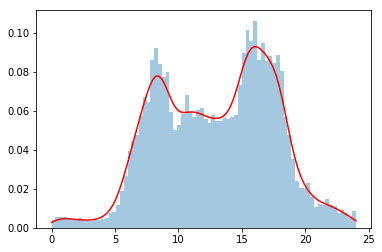

In [91]:
x=np.linspace(min(crashes_incidents_lite['Hour(HH.H)']),max(crashes_incidents_lite['Hour(HH.H)']),100)
y = model(x)
plt.hist(crashes_incidents_lite['Hour(HH.H)'], bins=80,density=True, alpha=0.4)
plt.plot(x,y,'r')

Above, we can see that the PDF is a good fit for the histogram. It is not very smooth and could further enhanced by setting the “bandwidth” argument to higher values.

### Calculating Probability

For a PDF, probability is obtained by calculating the integral over a range of values. As you noticed, that will lead to the probability 0 for a specific value.

In [111]:
# Get probability for range of values
start = 8.5  # Start time of the range
end = 9   # End time of the range

probability = model.integrate_box_1d(start,end) #  Approximate the integral of the PDF for each x
print(str(round(probability*100,1))+' %') # print probabititly 

3.8 %


Above, the given the pdf (propability distribution function) model determined by kernel desity estimation will estimate a probability of 3.8% of a crash between 8.30 - 9am

ideas for application - show likelihood of crashes in 3hour? 1hour? 15mins?  / Practicaility for use.

### Fit Possion Distribution 

A Poisson Process is a model for a series of discrete event where the average time between events is known, but the exact timing of events is random. 
The following criteria are used to model the Poisson processes however in reality many phenomena modelled don’t meet these exactly:
- Events are independent of each other. The occurrence of one event does not affect the probability another event will occur.
- The average rate (events per time period) is constant.
- Two events cannot occur at the same time.

Poisson random variable is typically used to model the number of times an event happened in a time interval.
An event can occur 0, 1, 2, … times in an interval. The average number of events in an interval is designated $\lambda\$ (lambda). Lambda is the event rate, also called the rate parameter. The probability of observing k events in an interval is given by the equation:



$$ P\ (k\ events\ in\ interval) = e^{ -\lambda\ }   \frac{ \lambda^k }{k!} $$


As an example how often would you expect to view a crash on network if we waited 

$ \lambda\ = \frac{1\ crash \ }{4\ hours\  } * 24\ hours = 6\ crashes\ expected $


Rate parameter for the meteor shower situation.


$$ P\ (3\ events\ in\ 1\ hour) = e^{ -6 }   \frac{ \ 6^3 }{3!} = 0.08923 = 8.9\% $$ 

That is 9% chance that we would see a 3 crash in one day.



In [173]:
crashes_incidents.head()

,coordinates,road,Region,type,loggedtime,blockagetype,Hour(HH.MM),Hour(HH.H),Indicator
4,"153.282180786,-27.8170452118",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 1:52,Unknown,1.52,1.9,1
6,"153.409698486,-27.9616641998",NORTH STREET,NaN,Crash,1/01/2011 2:34,Unknown,2.34,2.6,1
13,"152.948134889,-27.1015385732",MORAYFIELD ROAD,NaN,Crash,1/01/2011 8:01,Unknown,8.01,8.0,1
18,"153.044586182,-27.5152626038",PACIFIC MOTORWAY,NaN,Crash,1/01/2011 10:03,Partially Blocked,10.03,10.1,1
21,"153.03453064,-27.4136657715",GYMPIE ROAD,NaN,Crash,1/01/2011 10:45,Unknown,10.45,10.8,1


In [174]:
import pandas as pd
columns_of_interest = ['Hour(HH.H)','loggedtime']
crashes_incidents_possion = crashes_incidents[columns_of_interest]
crashes_incidents_possion.head()
#crashes_incidents_possion.dtypes
crashes_incidents_possion['Date'] = pd.to_datetime(crashes_incidents_possion['loggedtime'],dayfirst=True)
crashes_incidents_possion.dtypes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Hour(HH.H)           float64
loggedtime            object
Date          datetime64[ns]
dtype: object

In [133]:
del crashes_incidents_possion['loggedtime'] #remove original date column

KeyError: 'loggedtime'

In [177]:
crashes_incidents_possion.dtypes

,Hour(HH.H),loggedtime,Date
4,1.9,1/01/2011 1:52,2011-01-01 01:52:00
6,2.6,1/01/2011 2:34,2011-01-01 02:34:00
13,8.0,1/01/2011 8:01,2011-01-01 08:01:00
18,10.1,1/01/2011 10:03,2011-01-01 10:03:00
21,10.8,1/01/2011 10:45,2011-01-01 10:45:00
38,15.5,1/01/2011 15:29,2011-01-01 15:29:00
65,21.6,1/01/2011 21:37,2011-01-01 21:37:00
85,4.7,2/01/2011 4:42,2011-01-02 04:42:00
100,7.0,2/01/2011 7:00,2011-01-02 07:00:00
138,9.8,2/01/2011 9:49,2011-01-02 09:49:00


In [186]:
#group/count by day and then sort
crashes_incidents_possion_lite = crashes_incidents_possion['Date'].dt.date.value_counts().sort_index().reset_index()
crashes_incidents_possion_lite.columns = ['Date','Count']
crashes_incidents_possion_lite['Date'] = pd.to_datetime(crashes_incidents_possion_lite['Date'],dayfirst=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000439FFC50>]],
      dtype=object)

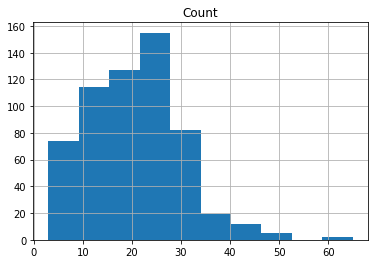

In [247]:
crashes_incidents_possion_lite.hist()

In [188]:
#crashes_incidents_possion_lite['Count'].describe()
crashes_incidents_possion.dtypes

Hour(HH.H)           float64
loggedtime            object
Date          datetime64[ns]
dtype: object

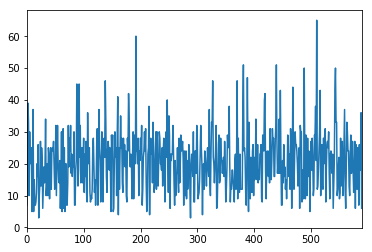

In [189]:
crashes_incidents_possion_lite['Count'].plot()

###### Above show nonstationarity. Need too look at outliers - proper cleaning of data requried here!!!
i.e remove holidays/extreme events etc

In [190]:
crashes_incidents_possion_lite_sort= crashes_incidents_possion_lite.sort_values(by='Count', ascending=False) #sort by count
crashes_incidents_possion_lite_sort.head(10) #show top ten worst days

,Date,Count
510,2012-05-25,65
192,2011-07-12,60
381,2012-01-17,51
439,2012-03-15,51
488,2012-05-03,50
543,2012-06-27,50
388,2012-01-24,47
138,2011-05-19,46
370,2012-01-06,46
327,2011-11-24,46


In [201]:
#crashes_incidents_possion_lite_sort_remove10 = crashes_incidents_possion_lite_sort[10:]
crashes_incidents_possion_lite_sort_remove10 = crashes_incidents_possion_lite_sort.iloc[10:]
crashes_incidents_possion_lite_sort_remove10.head(10)

,Date,Count
88,2011-03-30,45
92,2011-04-03,45
468,2012-04-13,44
516,2012-05-31,43
446,2012-03-22,43
542,2012-06-26,43
419,2012-02-24,42
179,2011-06-29,42
160,2011-06-10,41
247,2011-09-05,40


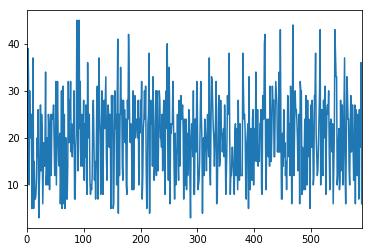

In [238]:
crashes_incidents_possion_lite_sort_remove10.dtypes
crashes_incidents_possion_lite_sort_remove10_sort = crashes_incidents_possion_lite_sort_remove10.sort_values(by='Date')
crashes_incidents_possion_lite_sort_remove10_sort.dtypes
crashes_incidents_possion_lite_sort_remove10_sort['Count'].plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000043A6DC88>]],
      dtype=object)

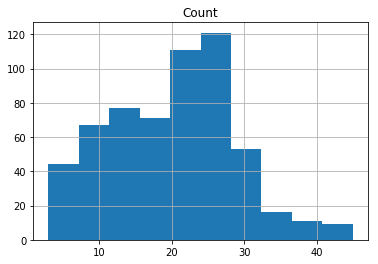

In [250]:
#crashes_incidents_possion_lite_sort_remove10_sort.hist(bins=50, density=True)
crashes_incidents_possion_lite_sort_remove10_sort.hist()

In [251]:
crash_count = crashes_incidents_possion_lite_sort_remove10_sort['Count'].values

AttributeError: 'numpy.ndarray' object has no attribute 'hist'

In [248]:
import scipy.stats
params = scipy.stats.uniform.fit(casualty)

### Hawkes process model

### Machine learning approach - neural network set as times series forcasting. 